In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Global variables
seed = 0  # For setting the random state
sample_size = 0.05
test_size = 0.3
target = 'meter_sale_price'

## **Problem Statement and Dataset Description**

A real estate company in the UAE wants to optimize its property valuation process by leveraging data analysis and machine learning algorithms. The company
has collected a vast amount of data related to property attributes, historical sales prices, market trends, and customer preferences. They aim to develop a
predictive model that can accurately estimate property values and assist in decision-making.

The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/alexefimik/dubai-real-estate-transactions-dataset). It contains information on several real estate transactions in Dubai, including property sales, rentals, and transfers. The dataset contains 1,047,965 rows and 46 columns. 14 out of the 46 columns serve as arabic translations to the categorical columns with values written in english.


The goal of the project is to build a model for predicting the value of a property. The `meter_sale_price` column will be used as the target variable in training a decision tree regressor and a linear regression model. The best model will be chosen after evaluation of the two.

## **Exploratory Data Analysis**

The dataset contains 1,047,965 rows. Using the full dataset would slow down model training significantly and could also potentially lead to overfitting. A random sample of the original dataset is therefore obtained. 

In [9]:
# Load all the data.
data = pd.read_csv("Transactions.csv")



In [10]:
# Obtain a random sample from the data
df = data.sample(frac=sample_size, axis=0, random_state=seed)
df.shape

(52398, 46)

It is necessary to drop columns that do not add any useful information to the model training. The following columns were dropped:
- Columns containing information that is specific to the transaction involved. Examples include `building_name` and `transaction_id`.
- Columns containing duplicate information. Fot instance, `property_type_id` is the numerical encoding of `property_type_en`.
- Columns that are arabic translation of other categorical columns. These columns have the suffix `_ar`. For example, the column `project_name_ar` is a translation of `project_name_en`
- Columns with >90% missing values from the original data. This is the case for the columns `rent_value` and `meter_rent_price` 
- Columns that cause target leakage. These are non-target columns containing information on rent and sale price, e.g. `actual_worth` and `rent_value`. Such information would not be available when evaluating a new property.

In [11]:
# Names of columns to be retained
cols = [
    'has_parking',
    'meter_sale_price',
    'no_of_parties_role_1',
    'no_of_parties_role_2',
    'no_of_parties_role_3',
    'procedure_area',
    'property_type_en',
    'property_sub_type_en',
    'reg_type_en',
    'property_usage_en',
    'rooms_en',
    'trans_group_en'
]

# Select the columns of interest and drop the rest
df = df[cols]
data = data[cols]
df.shape

(52398, 12)

In [12]:
df.head()

,has_parking,meter_sale_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,procedure_area,property_type_en,property_sub_type_en,reg_type_en,property_usage_en,rooms_en,trans_group_en
509256,0,5666.67,1.0,1.0,0.0,45.00,Unit,Flat,Existing Properties,Residential,Studio,Sales
829022,1,9447.03,1.0,1.0,0.0,79.39,Unit,Flat,Existing Properties,Residential,2 B/R,Sales
279902,1,3997.26,1.0,1.0,0.0,174.87,Unit,Flat,Existing Properties,Residential,3 B/R,Sales
530623,1,9043.21,1.0,1.0,0.0,74.23,Unit,Flat,Off-Plan Properties,Residential,1 B/R,Sales
258905,0,6485.34,2.0,1.0,0.0,254.42,Villa,Villa,Existing Properties,Residential,3 B/R,Mortgages


### **Missing Values**

The analysis below shows that about 24% of the rows have at least one missing value. Most of the missing values are attributed to the `rooms_en` and `property_sub_type_en` columns.

In [13]:
# Find the percentage of rows containing at least one missing value
df[df.isna().sum(axis=1) > 0].shape[0] / df.shape[0] * 100

23.55815107446849

In [14]:
# Find the percentage of observations with missing values in each column in the original dataset
data[cols].isna().sum().sort_values(ascending=False) / data.shape[0] * 100

rooms_en                23.754133
property_sub_type_en    22.915460
no_of_parties_role_1     0.109927
no_of_parties_role_2     0.109927
no_of_parties_role_3     0.109927
has_parking              0.000000
meter_sale_price         0.000000
procedure_area           0.000000
property_type_en         0.000000
reg_type_en              0.000000
property_usage_en        0.000000
trans_group_en           0.000000
dtype: float64

The cell below shows that 96% of the rows with missing values have NULL in both `rooms_en` and `property_sub_type_en` columns

In [15]:
# Rows with missing values in both columns
mask1 = data['rooms_en'].isna() & data['property_sub_type_en'].isna()
# Rows with at least one missing value in any column
mask2 = data.isna().sum(axis=1) > 0

mask1.sum() / mask2.sum() * 100

96.03496746793783

### **Data Integrity**

In [16]:
# Verify the data types of each column are as expected
df.dtypes

has_parking               int64
meter_sale_price        float64
no_of_parties_role_1    float64
no_of_parties_role_2    float64
no_of_parties_role_3    float64
procedure_area          float64
property_type_en         object
property_sub_type_en     object
reg_type_en              object
property_usage_en        object
rooms_en                 object
trans_group_en           object
dtype: object

Inspection of the data types reveals that `rooms_en` is categorical. This column describes the number of rooms in each property. The following analysis of the unique values reveals that the column is categorical instead of numerical because the dataset makes a distinction between ordinary rooms and bedrooms. Single Room properties are also not considered to be 1-bedroom. This column is therefore best left as categorical.

In [17]:
data['rooms_en'].value_counts().sort_values(ascending=False)

rooms_en
1 B/R          259994
2 B/R          187078
Studio         133956
3 B/R          109114
Office          56146
4 B/R           33572
Shop            11474
5 B/R            4279
PENTHOUSE        1687
Single Room       769
6 B/R             590
Store             321
7 B/R              27
GYM                17
8 B/R               4
9 B/R               2
Name: count, dtype: int64

In [18]:
# Verify that the `has_parking` column is binary.
data['has_parking'].unique()

array([0, 1], dtype=int64)

The analysis below shows that 4 properties in the original dataset have a value of zero, which is an anomaly. The entries can be safely dropped since their frequency is low.

In [19]:
# Verify that there are no abnormal property prices
print("Minimum house price per sq meter:", data[target].min())
print("Maximum house price per sq meter:", data[target].max())

Minimum house price per sq meter: 0.0
Maximum house price per sq meter: 34995777.3


In [20]:
# Get the count of properties with zero price
count_zero = (data[target] == 0).sum()
print(count_zero)

4


In [21]:
# Drop rows with zero property prices from the sample
zero_value_indices = df[(df[target] == 0)].index
df.drop(zero_value_indices, axis=0, inplace=True)

### **Data Distribution**

The distribution of the property prices is skewed to the right, indicating the presence of outliers comprising of properties whose value is very high. The non-normality of this data may significantly deteriorate the performance of linear regression models. Tree-based models are however not affected siginificantly by outliers. Trimming the top 10% of the data normalizes the data, indicating that most of the outliers are in the top 10th percentile. 

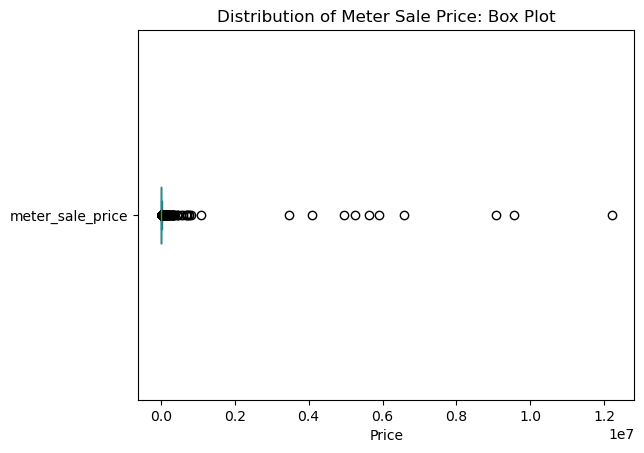

In [22]:
df[target].plot(kind='box', vert=False)
plt.title('Distribution of Meter Sale Price: Box Plot')
plt.xlabel('Price');

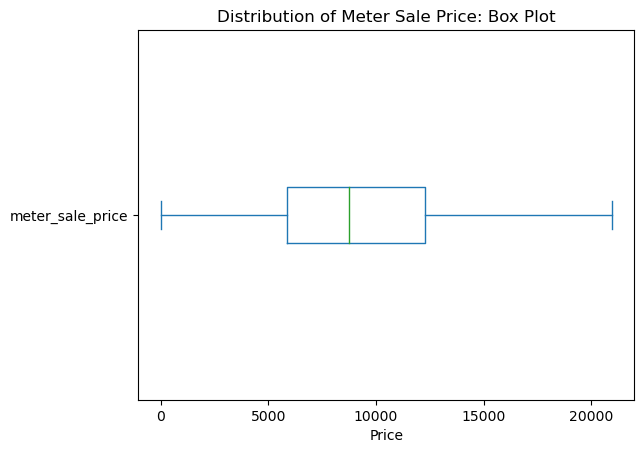

In [23]:
# Trim the top 15% of the data
lower_limit = df[target].min()
upper_limit = df[target].quantile(0.9)
df_trimmed = df[target][df[target].between(lower_limit, upper_limit)]
df_trimmed.plot(kind='box', vert=False)
plt.title('Distribution of Meter Sale Price: Box Plot')
plt.xlabel('Price');

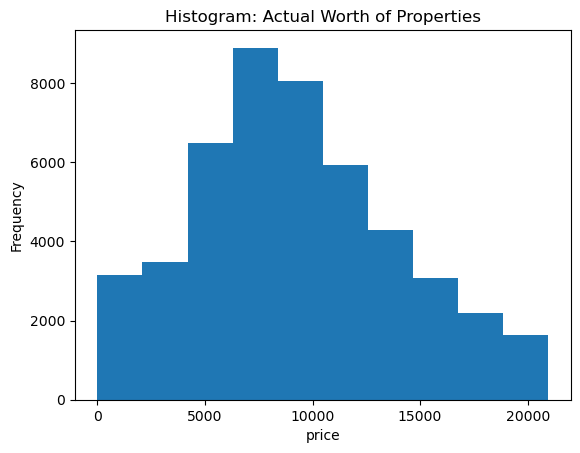

In [24]:
df_trimmed.plot(kind='hist')
plt.xlabel('price')
plt.title('Histogram: Actual Worth of Properties');

### **Correlation Matrix**

The correlation matrix of the numerical columns reveals moderate correlation between `no_of_parties_role_3` and `no_of_parties_role_2`. The correlation between the other features is weak. Collinearity is therefore not likely to have a significant impact on model performance. 

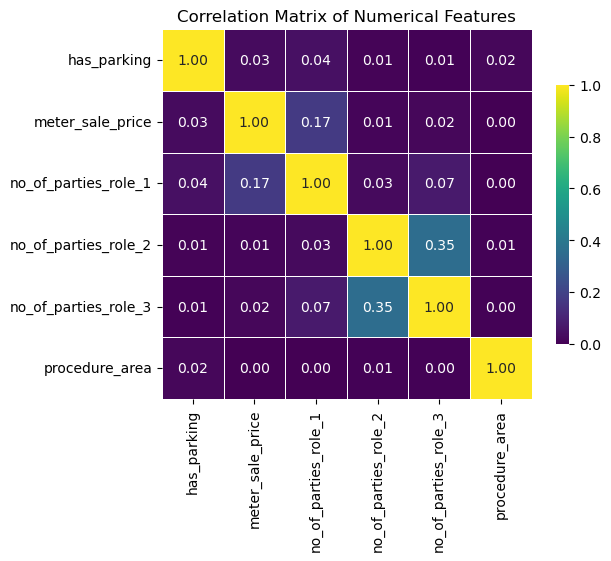

In [25]:
# Explore the absolute correlation among the features
corr = df.select_dtypes(include='number').corr().abs()
sns.heatmap(corr, vmax=1.0, vmin=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show();

## **Data Preparation**

### **Imputation of Missing Values**

Prior analysis revealed that about 24% of all rows in the original dataset had missing values. Out of these, 96% have NULL in both `rooms_en` and `property_sub_type_en` columns. The number of rows affected are too high to be dropped. The missing values in these two columns are therefore replaced with 'N/A'. This preserves any relationship that may exist between the reason for the missing values and the target variable. The remaining 4% of the missing values are thereafter dropped.

In [26]:
cols_ = ['rooms_en', 'property_sub_type_en']
df[cols_] = df[cols_].replace(np.NaN, 'N/A')

In [27]:
# Drop the remaining rows containing missing values
df.dropna(axis=0, inplace=True)

In [28]:
# Confirm that there are no missing values in the dataset
assert df[df.isna().sum(axis=1) > 0].shape[0] == 0

### **Categorical Encoding**

In [29]:
# Encode categorical features
df = pd.get_dummies(df)

### **Train-Test-Split**

In [30]:
# Separate the features from the target
X = df.drop(columns=target)
y = df[target]

assert X.shape[0] == y.shape[0]

In [31]:
X.shape, y.shape

((52347, 54), (52347,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## **Models Training and Evaluation**

In this section, selected models are trained without any optimization.

In [33]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=seed)

models = {
    'DT': dt,
    'LR': lr 
}

In [34]:
for model in models.values():
    model.fit(X_train, y_train)

### **Model Comparison**

The analysis below shows that the Decision Tree Regressor has better performance in terms of the R2 score and root mean square error. The decision tree is therefore the recommended model for predicting property prices. Comparison of the R2 score on the training and testing set reveals that the decision tree model does not suffer from significant overfitting since the difference in the metric does not differ significantly between the two sets of data.

In [35]:
def evaluate_models(models):
    """Calculate the r2_score and root mean squared error (RMSE) of each model.
    
    :Return: a DataFrame containing the metrics of each model. 
    """
    metrics = []

    for name, model in models.items():
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        metrics.append([r2, rmse])

    metrics_df = pd.DataFrame(
        data=metrics,
        columns=['r2_score', 'RMSE'],
        index = models.keys()
    ).round(3)

    return metrics_df

In [36]:
def plot_r2(metrics):
    # Plot the r2_scores
    ax = metrics.r2_score.plot(kind='bar')
    ax.set_xticklabels(metrics.index, rotation = 0)
    ax.set(title='r2 Scores');

def plot_rmse(metrics):
    # Plot the RMSE
    ax = metrics.RMSE.plot(kind='bar')
    ax.set_xticklabels(metrics.index, rotation = 0);
    ax.set(title='RMSE Scores');

In [37]:
metrics_df = evaluate_models(models)
metrics_df

,r2_score,RMSE
DT,0.897,46737.255
LR,0.004,145073.770


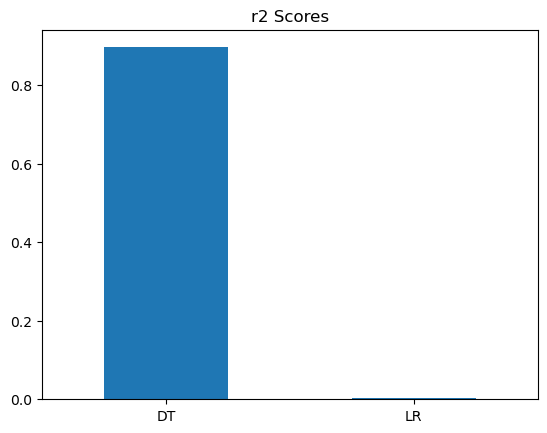

In [38]:
plot_r2(metrics_df)

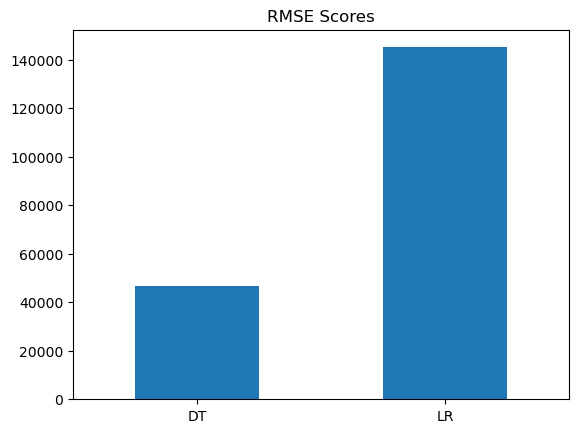

In [39]:
plot_rmse(metrics_df)

In [40]:
# Test for overfitting using r2_score by comparing the metric on the train and test sets
def test_overfitting(models):
    r2_scores = []
    for name, model in models.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_train_score = r2_score(y_train, y_train_pred)
        y_test_score = r2_score(y_test, y_test_pred)
        r2_scores.append([y_train_score, y_test_score])

    r2_score_df = pd.DataFrame(
        data=r2_scores,
        index=models.keys(),
        columns=['Training R2 Score', 'Testing R2 Score']
    ).round(3)
    print(r2_score_df)

    # Plot the R2 Scores
    ax = r2_score_df.plot(kind='bar')
    ax.set(title='Comparison of Training and Testing R2 Scores')
    ax.set_xticklabels(r2_score_df.index, rotation = 0);

    Training R2 Score  Testing R2 Score
DT              0.994             0.897
LR              0.086             0.004


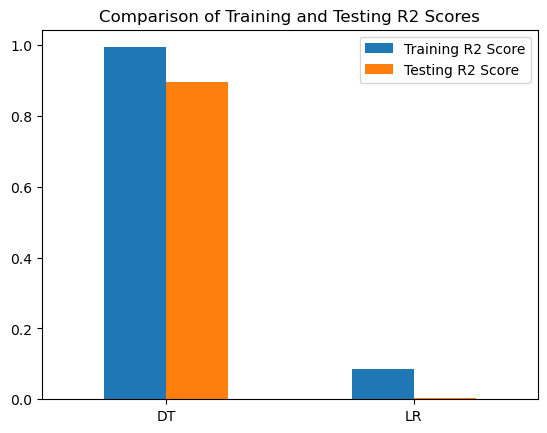

In [41]:
test_overfitting(models)

### **Feature Importances**

Feature importances indicate the features that are most significant in making predictions.This information is conveyed by the model coefficients for linear regression models. On the other hand, feature importances in tree-based model are conveyed by the Gini importance, which is accessible as an attribute on the trained model.

The analysis below shows that the property price per square meter is most highly influenced by:
- The total area of the property involved in the transaction.
- The number of parties involved with role 1 in the transaction

In [42]:
def plot_importances(importances, col_names, model_name):
    """Plot the top 10 feature importances for the models"""
    # Calculate the absolute value of the coefficients
    feat_imp = pd.Series(data=importances, index=col_names).abs()
    feat_imp.nlargest(10).sort_values().plot(kind='barh')
    # Plot the feature importances
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'{model_name}: Feature Importances')
    plt.show();

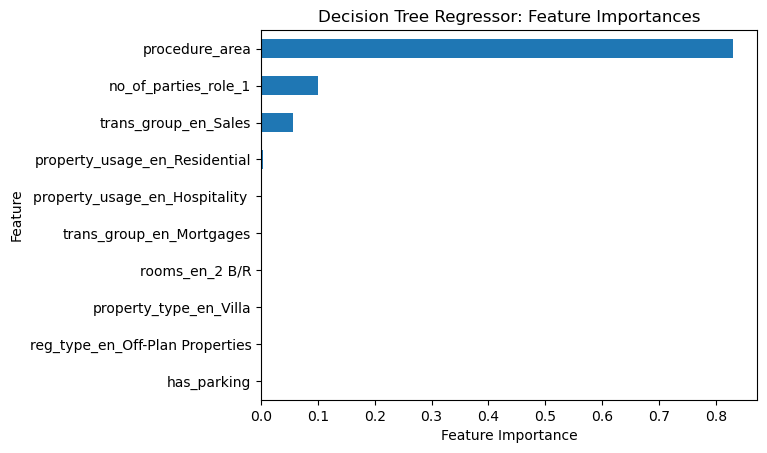

In [43]:
plot_importances(dt.feature_importances_, X.columns, 'Decision Tree Regressor')

## **Improvement of Model Performance**

The performance of the decision tree classifier can be improved using the following techniques:
- **Bagging**- this involves training separate decision trees with random subsets of the data. The final output is determined by combining the results from all the trees into a single value using suitable aggregatation strategies. This can be achieved in Scikit-Learn using the `RandomForestRegressor` model
- **Hyperparameter tuning** - this involves training the model iteratively using different values of the hyperparameters and obtaining the optimal set of values. sklearn has various algorithms for doing this, including `GridSearchCV` and `RandomizedSearchCV`

### Bagging using the `RandomForestRegressor` Model

The following assessment shows that using the random forest model provides better performance than the decision tree. The bagging technique yielded a higher R2 score and a lower RMSE. The random forest also has slightly lower overfitting. 

In [44]:
# Train and evaluate a RandomForestRegressor on the data
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [45]:
models = {"RF": rf, "DT": dt}

In [46]:
evaluate_models(models)

,r2_score,RMSE
RF,0.917,41914.793
DT,0.897,46737.255


    Training R2 Score  Testing R2 Score
RF              0.951             0.917
DT              0.994             0.897


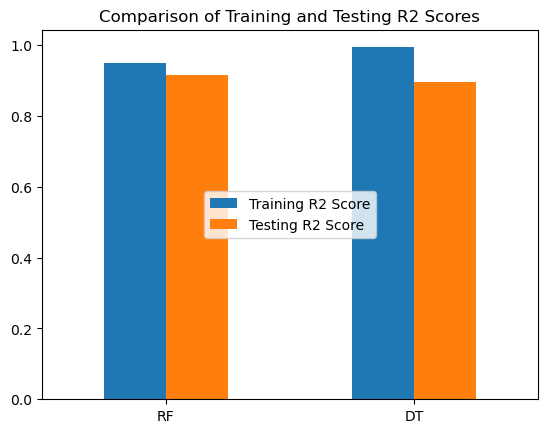

In [47]:
test_overfitting(models)
plt.legend(loc='center');

### Hyperparameter Tuning

Optimizing the hyperparameters of the decision tree regressor improved the R2 score and RMSE slightly but the change does not appear to be significant. There was also no significant change in overfitting. The optimization, however, revealed that the model performs best when the tree is as deep and possible and when all the features have been used in training.

In [48]:
# Optimize the Decision tree regressor using GridSearchCV
dt2 = DecisionTreeRegressor(random_state=seed)
dt_param_grid = {
    'max_depth': range(5, 15, 1),
    'min_samples_split': range(2, 10, 1),
    'max_features': ['sqrt', 'log2', len(X_train.columns)],
}
dt_cv = GridSearchCV(dt, dt_param_grid, cv=5, n_jobs=-1, scoring='r2')
dt_cv.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(5, 15),
                         'max_features': ['sqrt', 'log2', 54],
                         'min_samples_split': range(2, 10)},
             scoring='r2')

In [49]:
dt_cv.best_params_

{'max_depth': 9, 'max_features': 54, 'min_samples_split': 2}

In [50]:
models = {"DT": dt, "DT_optimized": dt_cv.best_estimator_}
evaluate_models(models)

,r2_score,RMSE
DT,0.897,46737.255
DT_optimized,0.899,46289.748


              Training R2 Score  Testing R2 Score
DT                        0.994             0.897
DT_optimized              0.971             0.899


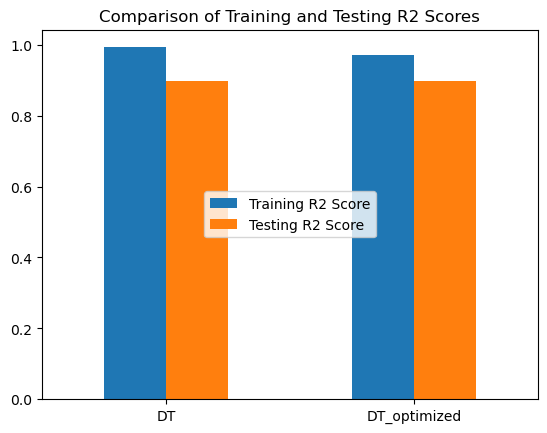

In [51]:
test_overfitting(models)
plt.legend(loc='center');